# Figure 5B, 5D and 5E

The code takes a long time to run. To reproduce the figures (without re-running all the code) is sufficient to run the section 'Heat maps'

## Import packages 

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from sympy import symbols, solve, simplify
import seaborn as sb
import pandas as pd
from scipy.optimize import curve_fit
from matplotlib.patches import Rectangle
plt.rcParams.update({'font.size': 20})
import multiprocess as mp
import time

# Definitions

Function to plot the heatmap

In [7]:
# My Heatmap
def myHeatmap(data, Min, Max, axs, label): 
    sb.heatmap(data,cmap=mymap,fmt=".4f",vmin=Min, vmax=Max, cbar=True, ax=axs, xticklabels=False, yticklabels=10, cbar_kws={'label': label,"orientation": "horizontal"}, center=-0.01)
    
# Find min and max values of the matrix
def min_array(data):
    min_temp = np.zeros(len(data))
    for i in range(len(data)): 
        min_temp[i]= min(data[i,:])
        
    min_final= min(min_temp)
    return min_final

def max_array(data):
    max_temp = np.zeros(len(data))
    for i in range(len(data)): 
        max_temp[i]= max(data[i,:])
        
    max_final= max(max_temp)
    return max_final

# Model 

Definition of the parameters of the model

In [4]:
T, V1, V2, K1, K2, Kb = symbols('T V1 V2 K1 K2 Kb') 
Vs, Rb, Ks, Vrg, Qb, Krg = symbols('Vs Rb Ks Vrg Qb Krg')
R, F, Kd, Q, E, Ke = symbols('R F Kd Q E Ke')
S1, Qtot, S2, Rtot= symbols('S1 Qtot S2 Rtot')

The evolution equation for T

In [13]:
# Evolution equation for T: 
expr = V1*(1-T)/(K1+(1-T))-V2*T/(K2+T)-Kb*T
expr_simplified= V1*(1-T)*(K2+T) -V2*T*(K1+(1-T))-Kb*T*(K1+(1-T))*(K2+T)
print('Evolution equation for T:')
print(expr)

# Substitute the expression for V1 and V2 in the evolution equation for T:  
expr_RQ= expr_simplified.subs([(V1, Vs*(R*F/(Kd+F))/(Ks+(R*F/(Kd+F)))),(V2, Vrg*(Q*E/(Ke+E))/(Krg+(Q*E/(Ke+E))))])

# Substitute the expressions for Q and R
expr_S1S2 = expr_RQ.subs([(R, Rtot*S1),(Q, Qtot*S2)])

# Expliciting the relation between S1 and S2 to obtain T(FGF, S1): 
expr_T = expr_S1S2.subs([(S2,-1.1265*S1 +0.9092)])

print('Evolution equation for T (all parameters explicited):')
print(expr_T)

# Solve the equation 
sol = solve(expr_T, T)[2]

Evolution equation for T:
-Kb*T - T*V2/(K2 + T) + V1*(1 - T)/(K1 - T + 1)
Evolution equation for T (all parameters explicited):
-E*Qtot*T*Vrg*(0.9092 - 1.1265*S1)*(K1 - T + 1)/((E + Ke)*(E*Qtot*(0.9092 - 1.1265*S1)/(E + Ke) + Krg)) + F*Rtot*S1*Vs*(1 - T)*(K2 + T)/((F + Kd)*(F*Rtot*S1/(F + Kd) + Ks)) - Kb*T*(K2 + T)*(K1 - T + 1)


Definition of the function ExprT that compute T as a function of all the parameters of the equation

In [14]:
def exprT(Vs_v=1, Vrg_v=0.4, K1_v=0.5, K2_v=0.2, Krg_v=1200, Ks_v=1200, Kb_v=0.2, F_v=5, Kd_v=25, E_v=5, Ke_v=50, Rtot_v=2000, Qtot_v=2000, S1_v=0.3):
    sol_T = sol.subs([(Vs,Vs_v),(Vrg,Vrg_v),(K1, K1_v),(K2,K2_v),(Krg, Krg_v), (Ks, Ks_v), (Kb, Kb_v),(F, F_v),(Kd, Kd_v),(E,E_v), (Ke, Ke_v),(Rtot, Rtot_v),(Qtot,Qtot_v),(S1,S1_v)])
    sol_T = np.real(np.array(sol_T,complex))
    return sol_T

Definition of the function to compute Erk (as a function of T):

In [15]:
def Erk(T,n=2, Kerk=0.5, Erk_max=1, Erk_bas=0): 
    Erk = [ Erk_max* T[i]**n/(T[i]**n +Kerk**n)+Erk_bas for i in range(len(T)) ]
    return Erk

# Results

In [16]:
# Definition of the parameters  
Kb_temp= np.linspace(0.01,1,50)
Kd_temp=  np.linspace(1,2000,50)
Ke_temp=  np.linspace(1,2000,50)
Ks_temp=  np.linspace(1,2000,50)
Krg_temp= np.linspace(1,2000,50)
K2_temp= np.linspace(0.01,1,50)
K1_temp= np.linspace(0.01,1,50)
Vrg_temp= np.linspace(0.01,1,50)
Vs_temp= np.linspace(0.01,1,50)
n_Ftemp = 50
n_Stemp = 50

# Compute S1*: 
S1_star = np.array(solve(-1.1265*S1 +0.9092, S1))
print('S1*=', S1_star[0])

# Define S1_temp: (vector from 0 to S1*)
LogS1star = np.log10(S1_star.astype(float))

S1*= 0.807101642254771


In [26]:
parameter_names = ['Vs_v','Vrg_v','Ks_v','Krg_v','K1_v','K2_v','Kd_v','Ke_v','Rtot_v','Qtot_v','Kb_v']
parameter_values_standard = [1,0.4,1200, 1200, 0.5,0.2,25,50,2000,2000,0.2]
param = dict(zip(parameter_names,parameter_values_standard))

# Define the functions 
def T_F(x_param):
    x, param_name, param_value= x_param
    param_temp = dict(zip(parameter_names,parameter_values_standard))
    param_temp[param_name] = param_value
    T_temp_F_mp = np.array([exprT(F_v =x[i], S1_v = 0.3, E_v =5, **param_temp) for i in range(len(x))])
    return T_temp_F_mp

def T_S1(x_param):
    x, param_name, param_value= x_param
    param_temp = dict(zip(parameter_names,parameter_values_standard))
    param_temp[param_name] = param_value
    T_temp_S1_mp = np.array([exprT(F_v =5, S1_v = x[i], E_v =5, **param_temp) for i in range(len(x))])
    return T_temp_S1_mp

def T_F_noEph(x_param):
    x, param_name, param_value= x_param
    param_temp = dict(zip(parameter_names,parameter_values_standard))
    param_temp[param_name] = param_value
    T_temp_F_mp = np.array([exprT(F_v =x[i], S1_v = 0.3, E_v=0.001, **param_temp) for i in range(len(x))])
    return T_temp_F_mp

def T_S1_noEph(x_param):
    x, param_name, param_value= x_param
    param_temp = dict(zip(parameter_names,parameter_values_standard))
    param_temp[param_name] = param_value
    T_temp_S1_mp = np.array([exprT(F_v =5, S1_v = x[i], E_v=0.001, **param_temp) for i in range(len(x))])
    return T_temp_S1_mp

def Erk_mp(T_temp):
    Erk_v = Erk(T_temp)
    return Erk_v

def model(x, a, b, c):
    return c*x**a/(x**a+b**a) 

def Hill_F_mp(y): 
    x = F_temp
    z= y-min(y)
    zR= z/max(z)
    popt, _ = curve_fit(model, x, zR, bounds=((0,0,0),(10,5000,10)))
    a,b,c = popt  
    return round(a,2)

def Hill_S1_mp(y): 
    x = S1_temp
    z= y-min(y)
    zR= z/max(z)
    popt, _ = curve_fit(model, x, zR, bounds=((0,0,0),(10,10,10)))
    a,b,c = popt  
    return round(a,2)

Erk as a function of [FGF], S1 for different values of Vrg¶

In [10]:
F_temp = np.logspace(-3,6,n_Ftemp) 
params= []
for i in range(len(Vrg_temp)): 
    params.append((F_temp, 'Vrg_v', Vrg_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_F, params)
    result_T_noEph = p.map(T_F_noEph, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    result_Erk_noEph = p.map(Erk_mp, result_T_noEph)
    # Compute the Hill coefficients
    n_Vrg_F = p.map(Hill_F_mp,result_Erk)
    n_Vrg_F_noEph = p.map(Hill_F_mp,result_Erk_noEph)

In [11]:
S1_temp= np.logspace(-3,LogS1star[0],n_Stemp)
params= []
for i in range(len(Vrg_temp)): 
    params.append((S1_temp, 'Vrg_v', Vrg_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S1, params)
    result_T_noEph = p.map(T_S1_noEph, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    result_Erk_noEph = p.map(Erk_mp, result_T_noEph)
    # Compute the Hill coefficients
    n_Vrg_S1 = p.map(Hill_S1_mp,result_Erk)
    n_Vrg_S1_noEph = p.map(Hill_S1_mp,result_Erk_noEph)

Erk as a function of [FGF], S1 for different values of Kb

In [13]:
F_temp = np.logspace(-4,5,n_Ftemp) 
params= []
for i in range(len(Vrg_temp)): 
    params.append((F_temp, 'Kb_v', Kb_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_F, params)
    result_T_noEph = p.map(T_F_noEph, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    result_Erk_noEph = p.map(Erk_mp, result_T_noEph)
    # Compute the Hill coefficients
    n_Kb_F = p.map(Hill_F_mp,result_Erk)
    n_Kb_F_noEph = p.map(Hill_F_mp,result_Erk_noEph)

In [14]:
S1_temp= np.logspace(-4,LogS1star[0],n_Stemp)
params= []
for i in range(len(Kb_temp)): 
    params.append((S1_temp, 'Kb_v', Kb_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S1, params)
    result_T_noEph = p.map(T_S1_noEph, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    result_Erk_noEph = p.map(Erk_mp, result_T_noEph)
    # Compute the Hill coefficients
    n_Kb_S1 = p.map(Hill_S1_mp,result_Erk)
    n_Kb_S1_noEph = p.map(Hill_S1_mp,result_Erk_noEph)

Erk as a function of [FGF], S1 for different values of Kd

In [77]:
F_temp = np.logspace(-4,7,n_Ftemp)
params= []
for i in range(len(Kd_temp)): 
    params.append((F_temp, 'Kd_v', Kd_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_F, params)
    result_T_noEph = p.map(T_F_noEph, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    result_Erk_noEph = p.map(Erk_mp, result_T_noEph)
    # Compute the Hill coefficients
    n_Kd_F = p.map(Hill_F_mp,result_Erk)
    n_Kd_F_noEph = p.map(Hill_F_mp,result_Erk_noEph)

In [78]:
S1_temp= np.logspace(-3,LogS1star[0],n_Stemp)
params= []
for i in range(len(Kd_temp)): 
    params.append((S1_temp, 'Kd_v', Kd_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S1, params)
    result_T_noEph = p.map(T_S1_noEph, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    result_Erk_noEph = p.map(Erk_mp, result_T_noEph)
    # Compute the Hill coefficients
    n_Kd_S1 = p.map(Hill_S1_mp,result_Erk)
    n_Kd_S1_noEph = p.map(Hill_S1_mp,result_Erk_noEph)

Erk as a function of [FGF], S1 for different values of Ke

In [19]:
F_temp = np.logspace(-3,5,n_Ftemp) 
params= []
for i in range(len(Ke_temp)): 
    params.append((F_temp, 'Ke_v', Ke_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_F, params)
    result_T_noEph = p.map(T_F_noEph, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    result_Erk_noEph = p.map(Erk_mp, result_T_noEph)
    # Compute the Hill coefficients
    n_Ke_F = p.map(Hill_F_mp,result_Erk)
    n_Ke_F_noEph = p.map(Hill_F_mp,result_Erk_noEph)

In [20]:
S1_temp= np.logspace(-3,LogS1star[0],n_Stemp)
params= []
for i in range(len(Ke_temp)): 
    params.append((S1_temp, 'Ke_v', Ke_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S1, params)
    result_T_noEph = p.map(T_S1_noEph, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    result_Erk_noEph = p.map(Erk_mp, result_T_noEph)
    # Compute the Hill coefficients
    n_Ke_S1 = p.map(Hill_S1_mp,result_Erk)
    n_Ke_S1_noEph = p.map(Hill_S1_mp,result_Erk_noEph)


Erk as a function of [FGF], S1 for different values of K1

In [22]:
F_temp = np.logspace(-3,4,n_Ftemp)
params= []
for i in range(len(K1_temp)): 
    params.append((F_temp, 'K1_v', K1_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_F, params)
    result_T_noEph = p.map(T_F_noEph, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    result_Erk_noEph = p.map(Erk_mp, result_T_noEph)
    # Compute the Hill coefficients
    n_K1_F = p.map(Hill_F_mp,result_Erk)
    n_K1_F_noEph = p.map(Hill_F_mp,result_Erk_noEph)

In [23]:
S1_temp= np.logspace(-3,LogS1star[0],n_Stemp)
params= []
for i in range(len(K1_temp)): 
    params.append((S1_temp, 'K1_v', K1_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S1, params)
    result_T_noEph = p.map(T_S1_noEph, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    result_Erk_noEph = p.map(Erk_mp, result_T_noEph)
    # Compute the Hill coefficients
    n_K1_S1 = p.map(Hill_S1_mp,result_Erk)
    n_K1_S1_noEph = p.map(Hill_S1_mp,result_Erk_noEph)

Erk as a function of [FGF], S1 for different values of K2

In [25]:
F_temp = np.logspace(-3,4,n_Ftemp)
params= []
for i in range(len(K2_temp)): 
    params.append((F_temp, 'K2_v', K2_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_F, params)
    result_T_noEph = p.map(T_F_noEph, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    result_Erk_noEph = p.map(Erk_mp, result_T_noEph)
    # Compute the Hill coefficients
    n_K2_F = p.map(Hill_F_mp,result_Erk)
    n_K2_F_noEph = p.map(Hill_F_mp,result_Erk_noEph)

In [26]:
S1_temp= np.logspace(-3,LogS1star[0],n_Stemp)
params= []
for i in range(len(K2_temp)): 
    params.append((S1_temp, 'K2_v', K2_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S1, params)
    result_T_noEph = p.map(T_S1_noEph, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    result_Erk_noEph = p.map(Erk_mp, result_T_noEph)
    # Compute the Hill coefficients
    n_K2_S1 = p.map(Hill_S1_mp,result_Erk)
    n_K2_S1_noEph = p.map(Hill_S1_mp,result_Erk_noEph)


Erk as a function of [FGF], S1 for different values of Vs

In [28]:
F_temp = np.logspace(-3,6,n_Ftemp)
params= []
for i in range(len(Vs_temp)): 
    params.append((F_temp, 'Vs_v', Vs_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_F, params)
    result_T_noEph = p.map(T_F_noEph, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    result_Erk_noEph = p.map(Erk_mp, result_T_noEph)
    # Compute the Hill coefficients
    n_Vs_F = p.map(Hill_F_mp,result_Erk)
    n_Vs_F_noEph = p.map(Hill_F_mp,result_Erk_noEph)

In [29]:
S1_temp= np.logspace(-3,LogS1star[0],n_Stemp)
params= []
for i in range(len(Vs_temp)): 
    params.append((S1_temp, 'Vs_v', Vs_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S1, params)
    result_T_noEph = p.map(T_S1_noEph, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    result_Erk_noEph = p.map(Erk_mp, result_T_noEph)
    # Compute the Hill coefficients
    n_Vs_S1 = p.map(Hill_S1_mp,result_Erk)
    n_Vs_S1_noEph = p.map(Hill_S1_mp,result_Erk_noEph)


Erk as a function of [FGF], S1 for different values of Ks

In [31]:
F_temp = np.logspace(-6,5,n_Ftemp)
params= []
for i in range(len(Ks_temp)): 
    params.append((F_temp, 'Ks_v', Ks_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_F, params)
    result_T_noEph = p.map(T_F_noEph, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    result_Erk_noEph = p.map(Erk_mp, result_T_noEph)
    # Compute the Hill coefficients
    n_Ks_F = p.map(Hill_F_mp,result_Erk)
    n_Ks_F_noEph = p.map(Hill_F_mp,result_Erk_noEph)

In [32]:
S1_temp= np.logspace(-6,LogS1star[0],n_Stemp)
params= []
for i in range(len(Ks_temp)): 
    params.append((S1_temp, 'Ks_v', Ks_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S1, params)
    result_T_noEph = p.map(T_S1_noEph, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    result_Erk_noEph = p.map(Erk_mp, result_T_noEph)
    # Compute the Hill coefficients
    n_Ks_S1 = p.map(Hill_S1_mp,result_Erk)
    n_Ks_S1_noEph = p.map(Hill_S1_mp,result_Erk_noEph)

Erk as a function of [FGF], S1 for different values of Krg

In [34]:
F_temp = np.logspace(-3,5,n_Ftemp)
params= []
for i in range(len(Krg_temp)): 
    params.append((F_temp, 'Krg_v', Krg_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_F, params)
    result_T_noEph = p.map(T_F_noEph, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    result_Erk_noEph = p.map(Erk_mp, result_T_noEph)
    # Compute the Hill coefficients
    n_Krg_F = p.map(Hill_F_mp,result_Erk)
    n_Krg_F_noEph = p.map(Hill_F_mp,result_Erk_noEph)

In [35]:
S1_temp= np.logspace(-3,LogS1star[0],n_Stemp)
params= []
for i in range(len(Krg_temp)): 
    params.append((S1_temp, 'Krg_v', Krg_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S1, params)
    result_T_noEph = p.map(T_S1_noEph, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    result_Erk_noEph = p.map(Erk_mp, result_T_noEph)
    # Compute the Hill coefficients
    n_Krg_S1 = p.map(Hill_S1_mp,result_Erk)
    n_Krg_S1_noEph = p.map(Hill_S1_mp,result_Erk_noEph)

In [80]:
# Compute the difference: n[Erk(S1)] - n[Erk(FGF)]  
diff_Kb = np.array(n_Kb_S1) - np.array(n_Kb_F)
diff_Kd = np.array(n_Kd_S1) - np.array(n_Kd_F)
diff_Ke = np.array(n_Ke_S1) - np.array(n_Ke_F)
diff_Ks = np.array(n_Ks_S1) - np.array(n_Ks_F)
diff_Krg = np.array(n_Krg_S1) - np.array(n_Krg_F)
diff_K1 = np.array(n_K1_S1) - np.array(n_K1_F)
diff_K2 = np.array(n_K2_S1) - np.array(n_K2_F)
diff_Vs = np.array(n_Vs_S1) - np.array(n_Vs_F)
diff_Vrg = np.array(n_Vrg_S1) - np.array(n_Vrg_F)

# Combine all the data in a single array 
data_01_5B= np.stack((diff_Kb, diff_K1, diff_K2, diff_Vs, diff_Vrg) , axis=-1)
data_02000_5B= np.stack((diff_Ks, diff_Krg, diff_Kd, diff_Ke) , axis=-1)

# Save the data in a .txt file 
np.savetxt('results_01_5B.txt', data_01_5B)
np.savetxt('results_02000_5B.txt', data_02000_5B)

In [81]:
# Compute the difference: n[Erk]eph - n[Erk]noEph  (Erk[S1])
diff_Kb_S1 = np.array(n_Kb_S1) - np.array(n_Kb_S1_noEph)
diff_Kd_S1 = np.array(n_Kd_S1) - np.array(n_Kd_S1_noEph)
diff_Ke_S1 = np.array(n_Ke_S1) - np.array(n_Ke_S1_noEph)
diff_Ks_S1 = np.array(n_Ks_S1) - np.array(n_Ks_S1_noEph)
diff_Krg_S1 = np.array(n_Krg_S1) - np.array(n_Krg_S1_noEph)
diff_K1_S1 = np.array(n_K1_S1) - np.array(n_K1_S1_noEph)
diff_K2_S1 = np.array(n_K2_S1) - np.array(n_K2_S1_noEph)
diff_Vs_S1 = np.array(n_Vs_S1) - np.array(n_Vs_S1_noEph)
diff_Vrg_S1 = np.array(n_Vrg_S1) - np.array(n_Vrg_S1_noEph)

# Combine all the data in a single array 
data_01_5D= np.stack((diff_Kb_S1, diff_K1_S1, diff_K2_S1, diff_Vs_S1, diff_Vrg_S1) , axis=-1)
data_02000_5D= np.stack((diff_Ks_S1, diff_Krg_S1, diff_Kd_S1, diff_Ke_S1) , axis=-1)

# Save the data in a .txt file 
np.savetxt('results_01_5D.txt', data_01_5D)
np.savetxt('results_02000_5D.txt', data_02000_5D)

In [83]:
# Compute the difference: n[Erk]eph - n[Erk]noEph  (Erk[FGF])
diff_Kb_F = np.array(n_Kb_F) - np.array(n_Kb_F_noEph)
diff_Kd_F = np.array(n_Kd_F) - np.array(n_Kd_F_noEph)
diff_Ke_F = np.array(n_Ke_F) - np.array(n_Ke_F_noEph)
diff_Ks_F = np.array(n_Ks_F) - np.array(n_Ks_F_noEph)
diff_Krg_F = np.array(n_Krg_F) -np.array(n_Krg_F_noEph)
diff_K1_F = np.array(n_K1_F) - np.array(n_K1_F_noEph)
diff_K2_F = np.array(n_K2_F) - np.array(n_K2_F_noEph)
diff_Vs_F = np.array(n_Vs_F) - np.array(n_Vs_F_noEph)
diff_Vrg_F = np.array(n_Vrg_F) -np.array(n_Vrg_F_noEph)

# Combine all the data in a single array 
data_01_5E= np.stack((diff_Kb_F, diff_K1_F, diff_K2_F, diff_Vs_F, diff_Vrg_F), axis=-1)
data_02000_5E= np.stack((diff_Ks_F, diff_Krg_F, diff_Kd_F, diff_Ke_F), axis=-1)

# Save the data in a .txt file 
np.savetxt('results_01_5E.txt', data_01_5E)
np.savetxt('results_02000_5E.txt', data_02000_5E)

## Heat maps

In [8]:
# Define the colormap
import matplotlib.colors as mcolors

# sample the colormaps that you want to use. Use 128 from each so we get 256 colors in total
colors1 = plt.cm.Blues_r(np.linspace(0., 0.8, 128))
colors2 = plt.cm.Reds(np.linspace(0,1,128))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

### Figure 5B

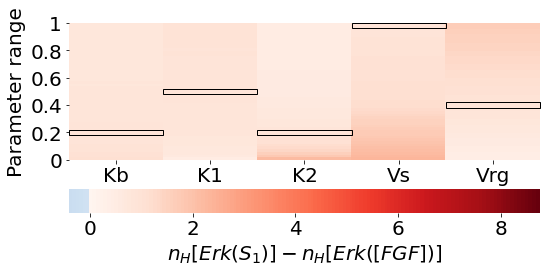

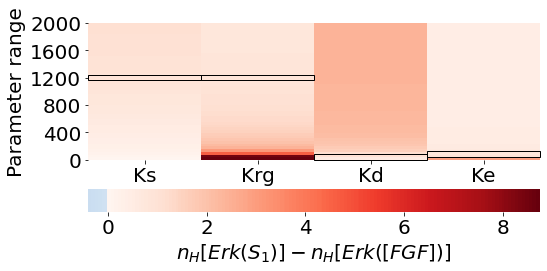

In [12]:
# Load the data 
data_01_5B_load = np.loadtxt('results_01_5B.txt')
data_02000_5B_load = np.loadtxt('results_02000_5B.txt')

# Create the heatmap

# Left panel: Parameters from 0 to 1
Min= -0.4 
Max= max_array(data_02000_5B_load)

fig = plt.figure(figsize=(8,4))
axs = fig.gca()
myHeatmap(data_01_5B_load,Min,Max, axs, label='$n_H[Erk(S_1)]-n_H[Erk([FGF])]$')

axs.add_patch(Rectangle((0, 9), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((1, 24), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((2, 9), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((3, 48), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((4, 19), 1, 2, fill=False, edgecolor='black', lw=1,clip_on=False))

axs.set_ylabel('Parameter range')
axs.set_xticks([0.5,1.5,2.5,3.5, 4.5])
axs.set_xticklabels(['Kb','K1','K2','Vs', 'Vrg'])
axs.set_yticks([0,10,20, 30, 40, 50])
axs.set_yticklabels(['0','0.2','0.4', '0.6', '0.8', '1'],rotation = 0)
axs.invert_yaxis()
plt.tight_layout()
plt.show()

# Right panel: Parameters from 0 to 2000
Min= -0.4 
Max= max_array(data_02000_5B_load)

fig = plt.figure(figsize=(8,4))
axs = fig.gca()
myHeatmap(data_02000_5B_load,Min,Max, axs,label='$n_H[Erk(S_1)]-n_H[Erk([FGF])]$')

axs.add_patch(Rectangle((0, 29), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((1, 29), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((2, 0), 1, 2, fill=False, edgecolor='black', lw=1, clip_on=False))
axs.add_patch(Rectangle((3, 1), 1, 2, fill=False, edgecolor='black', lw=1, clip_on=False))

axs.set_ylabel('Parameter range')
axs.set_xticks([0.5,1.5,2.5,3.5])
axs.set_xticklabels(['Ks','Krg','Kd','Ke'])
axs.set_yticks([0,10,20, 30, 40, 50])
axs.set_yticklabels(['0','400','800', '1200', '1600', '2000'],rotation = 0)
axs.invert_yaxis()
plt.tight_layout()
plt.show()

### Figure 5D

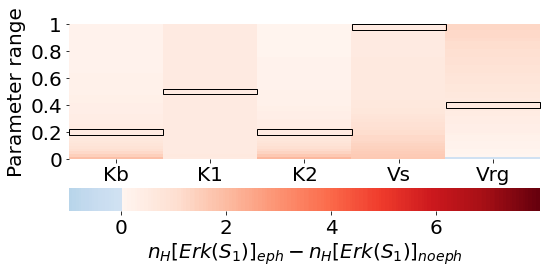

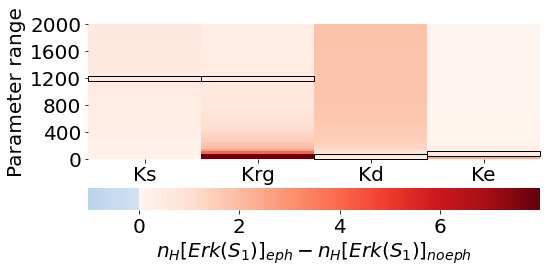

In [13]:
# Load the data 
data_01_5D_load = np.loadtxt('results_01_5D.txt')
data_02000_5D_load = np.loadtxt('results_02000_5D.txt')

# Create the heatmap

# Left panel: Parameters from 0 to 1
Min= - 1 
Max= max_array(data_02000_5D_load)

fig = plt.figure(figsize=(8,4))
axs = fig.gca()
myHeatmap(data_01_5D_load,Min,Max, axs, label='$n_H[Erk(S_1)]_{eph}-n_H[Erk(S_1)]_{no eph}$')

axs.add_patch(Rectangle((0, 9), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((1, 24), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((2, 9), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((3, 48), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((4, 19), 1, 2, fill=False, edgecolor='black', lw=1,clip_on=False))

axs.set_ylabel('Parameter range')
axs.set_xticks([0.5,1.5,2.5,3.5, 4.5])
axs.set_xticklabels(['Kb','K1','K2','Vs', 'Vrg'])
axs.set_yticks([0,10,20, 30, 40, 50])
axs.set_yticklabels(['0','0.2','0.4', '0.6', '0.8', '1'],rotation = 0)
axs.invert_yaxis()
plt.tight_layout()
plt.show()

# Rigth panel: Parameters from 0 to 2000
Min= - 1 
Max= max_array(data_02000_5D_load)

fig = plt.figure(figsize=(8,4))
axs = fig.gca()
myHeatmap(data_02000_5D_load,Min,Max, axs,label='$n_H[Erk(S_1)]_{eph}-n_H[Erk(S_1)]_{no eph}$')

axs.add_patch(Rectangle((0, 29), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((1, 29), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((2, 0), 1, 2, fill=False, edgecolor='black', lw=1, clip_on=False))
axs.add_patch(Rectangle((3, 1), 1, 2, fill=False, edgecolor='black', lw=1, clip_on=False))

axs.set_ylabel('Parameter range')
axs.set_xticks([0.5,1.5,2.5,3.5])
axs.set_xticklabels(['Ks','Krg','Kd','Ke'])
axs.set_yticks([0,10,20, 30, 40, 50])
axs.set_yticklabels(['0','400','800', '1200', '1600', '2000'],rotation = 0)
axs.invert_yaxis()
plt.tight_layout()
plt.show()

### Figure 5E

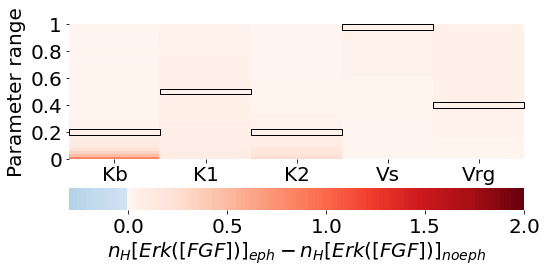

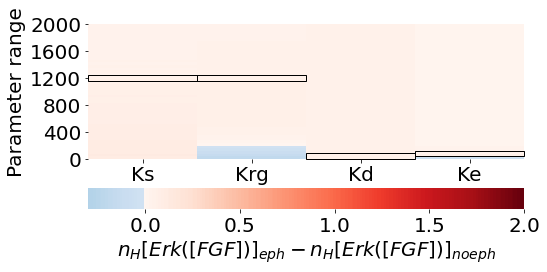

In [14]:
# Load the data 
data_01_5E_load = np.loadtxt('results_01_5E.txt')
data_02000_5E_load = np.loadtxt('results_02000_5E.txt')

# Create the heatmap

# Left panel: Parameters from 0 to 1
Min= - 0.3
Max= 2 

fig = plt.figure(figsize=(8,4))
axs = fig.gca()
myHeatmap(data_01_5E_load,Min,Max, axs, label='$n_H[Erk([FGF])]_{eph}-n_H[Erk([FGF])]_{no eph}$')

axs.add_patch(Rectangle((0, 9), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((1, 24), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((2, 9), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((3, 48), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((4, 19), 1, 2, fill=False, edgecolor='black', lw=1,clip_on=False))

axs.set_ylabel('Parameter range')
axs.set_xticks([0.5,1.5,2.5,3.5, 4.5])
axs.set_xticklabels(['Kb','K1','K2','Vs', 'Vrg'])
axs.set_yticks([0,10,20, 30, 40, 50])
axs.set_yticklabels(['0','0.2','0.4', '0.6', '0.8', '1'],rotation = 0)
axs.invert_yaxis()
plt.tight_layout()
plt.show()

# Rigth panel: Parameters from 0 to 2000
Min= -0.3
Max= 2 

fig = plt.figure(figsize=(8,4))
axs = fig.gca()
myHeatmap(data_02000_5E_load,Min,Max, axs,label='$n_H[Erk([FGF])]_{eph}-n_H[Erk([FGF])]_{no eph}$')

axs.add_patch(Rectangle((0, 29), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((1, 29), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((2, 0), 1, 2, fill=False, edgecolor='black', lw=1, clip_on=False))
axs.add_patch(Rectangle((3, 1), 1, 2, fill=False, edgecolor='black', lw=1, clip_on=False))

axs.set_ylabel('Parameter range')
axs.set_xticks([0.5,1.5,2.5,3.5])
axs.set_xticklabels(['Ks','Krg','Kd','Ke'])
axs.set_yticks([0,10,20, 30, 40, 50])
axs.set_yticklabels(['0','400','800', '1200', '1600', '2000'],rotation = 0)
axs.invert_yaxis()
plt.tight_layout()
plt.show()